# AIN 214 PA3 on Data Prepocessing and Regression

# THE STUDENT INFO
## Student Name: Adam Sattout
## Student ID: 2220765061

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder


# Load the dataset
# Replace 'path_to_dataset' with the actual file path
path_to_dataset = 'housing.csv'
housing_df = pd.read_csv(path_to_dataset)

# We will deal with the famous California Housing Prices dataset from Kaggle. [1]

# 1. Data Preprocessing (50 Pts)

## 1.1. Explaratory Data Analysis (10 Pts)

* Check for missing values
* Visualize the features with any relevant plots to understand the distribution of data
* Visualize the target variable with respect to the features 
* Visualize the correlation between the features using a heatmap
* Comment on any findings

In [2]:
print("Missing values in each column:")
print(housing_df.isnull().sum())

#We can see only missing values are in total_bedrooms so we can remove those
housing_df = housing_df.dropna(subset=['total_bedrooms'])

Missing values in each column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


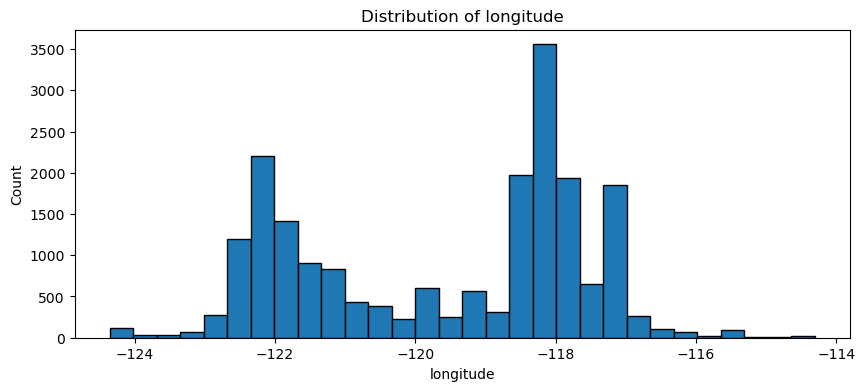

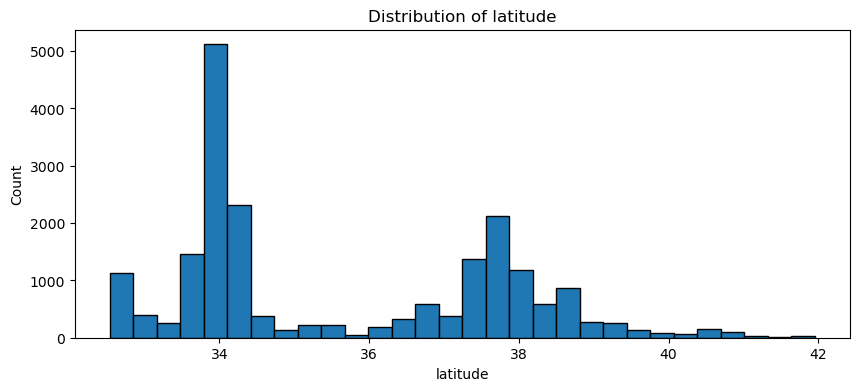

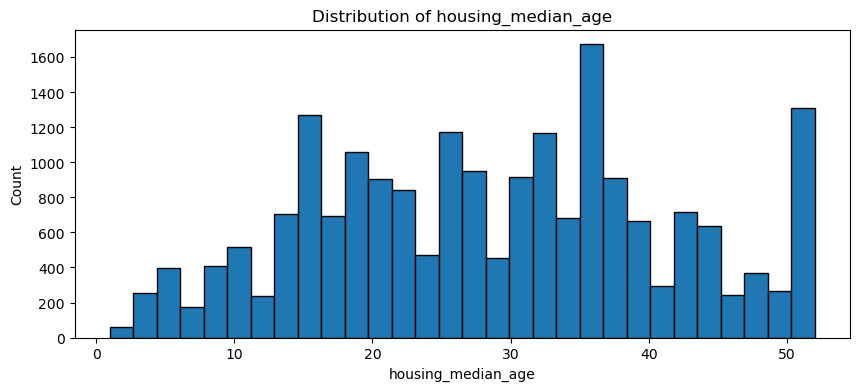

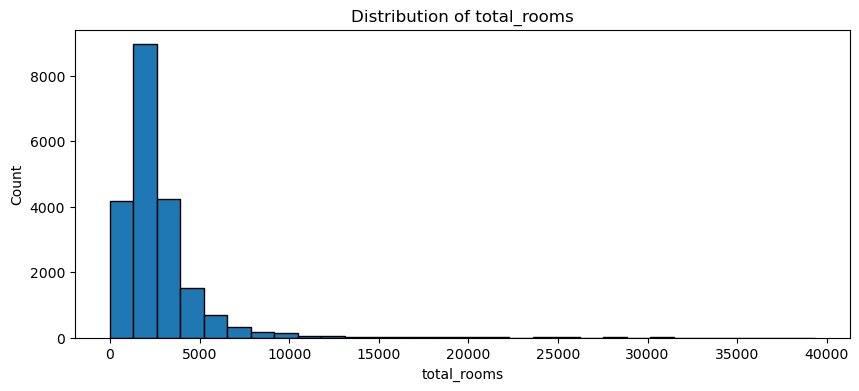

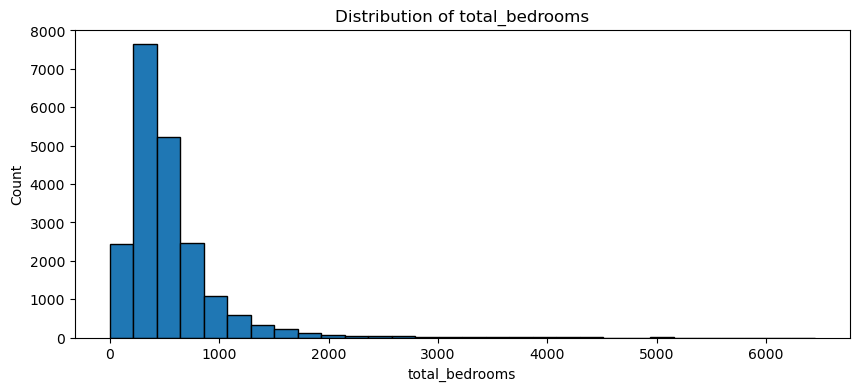

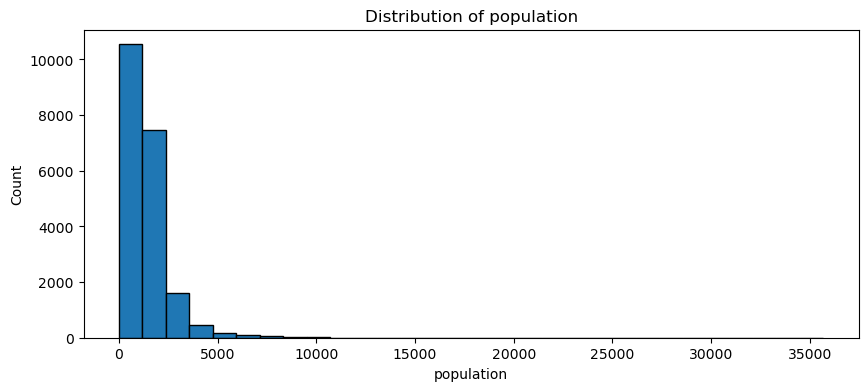

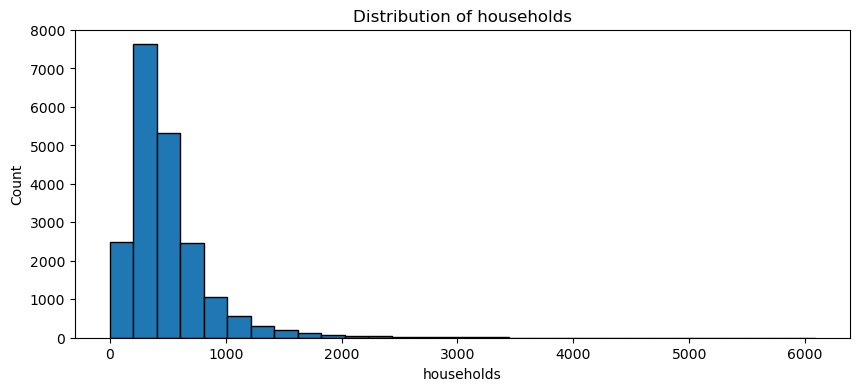

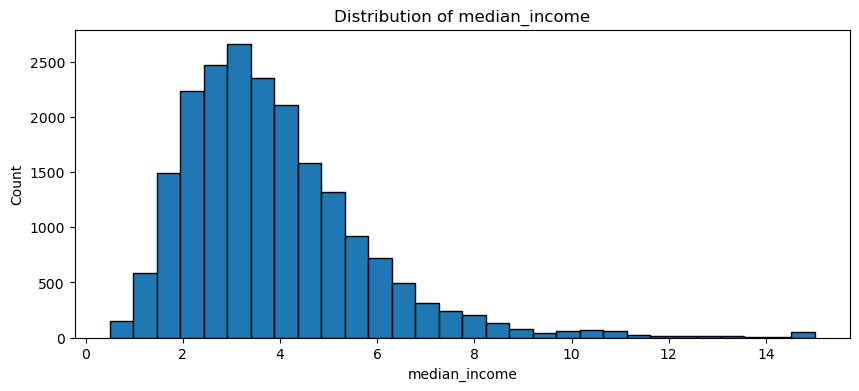

In [3]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
            'population', 'households', 'median_income']

for feature in features:
    plt.figure(figsize=(10, 4))
    plt.hist(housing_df[feature].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()
    

For median_age, longitude, and latitude, we can see that they dont have a uniform distribution but each have a distinguishable mode, espically for the former ones. However, other features have a clear unimodal uniform distribution that is lightly right skewed with multiple outliers on the right.

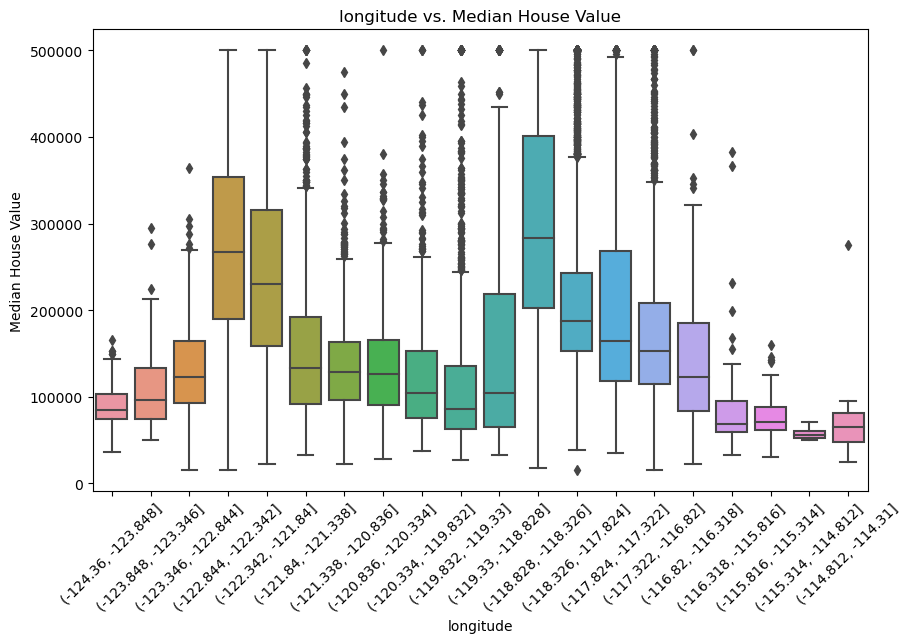

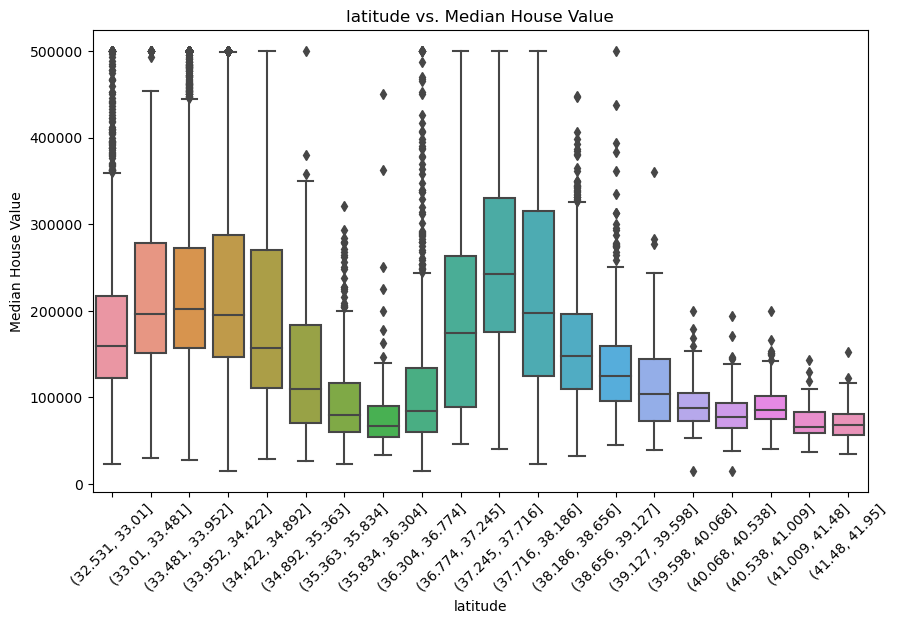

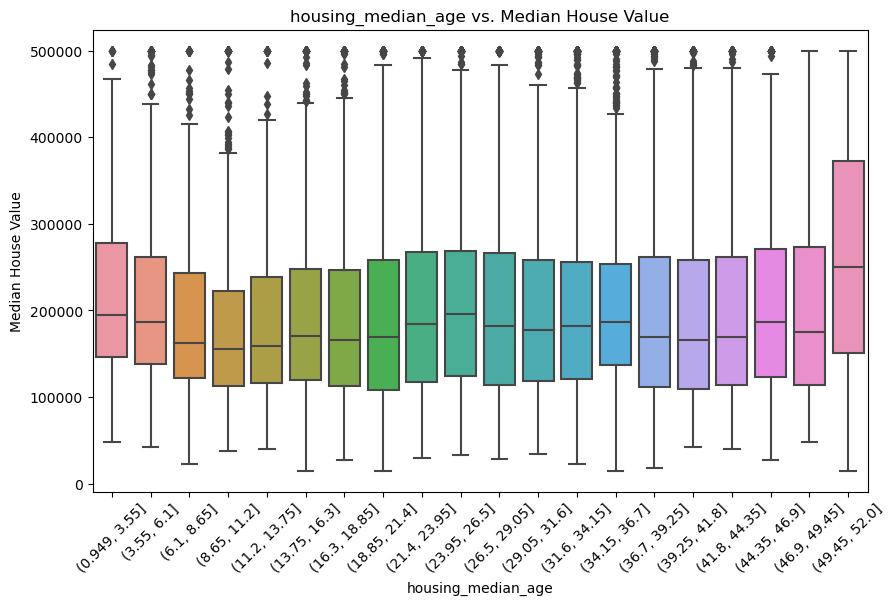

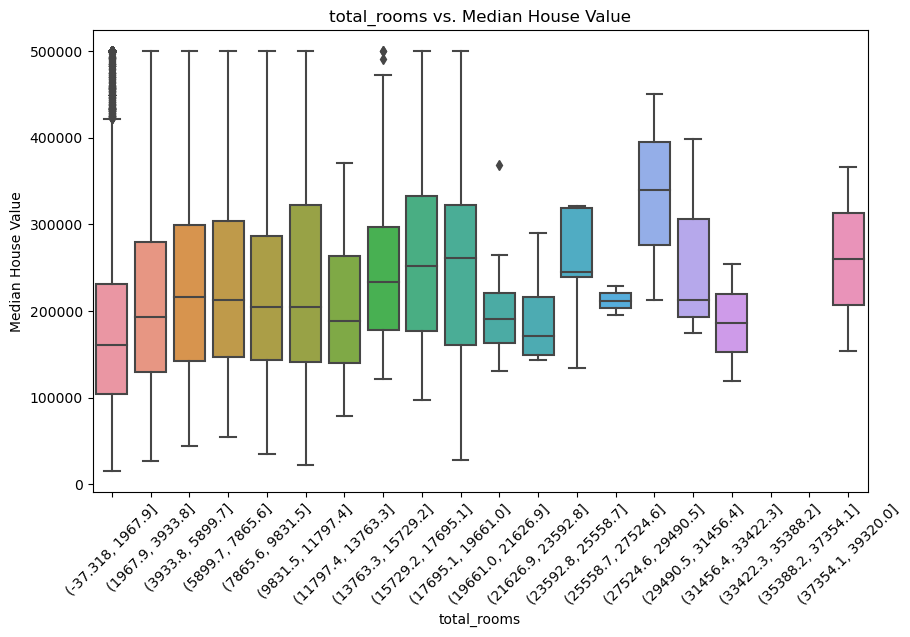

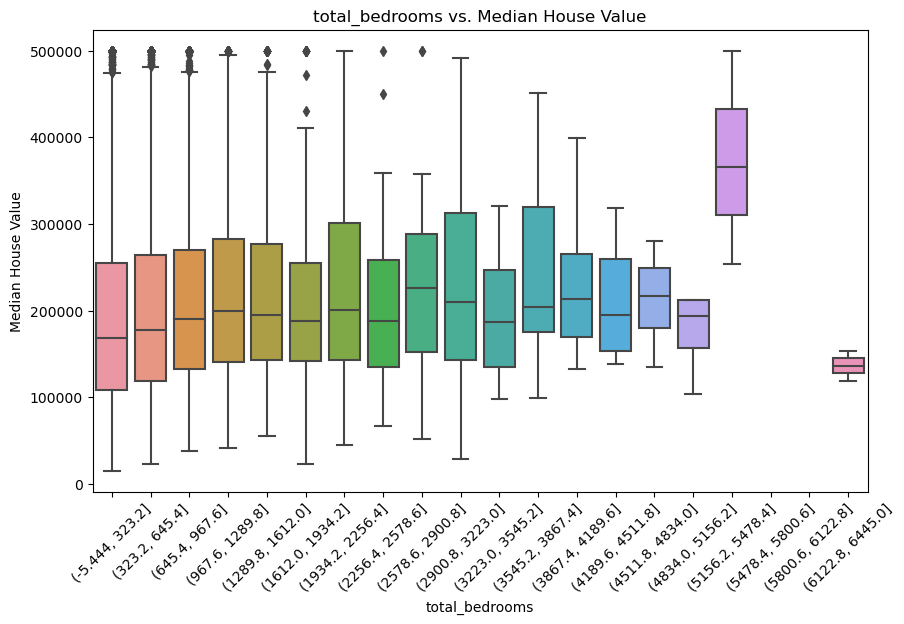

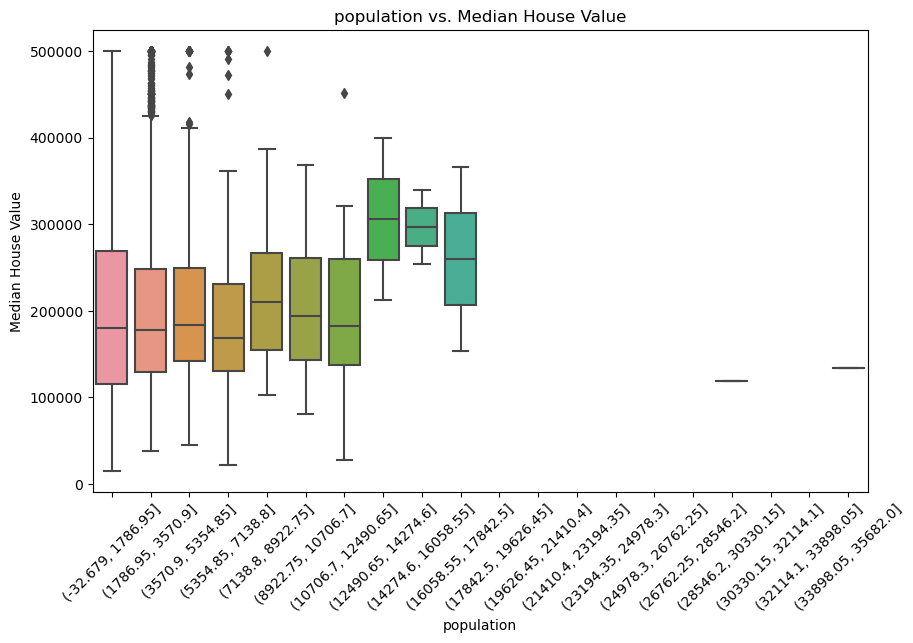

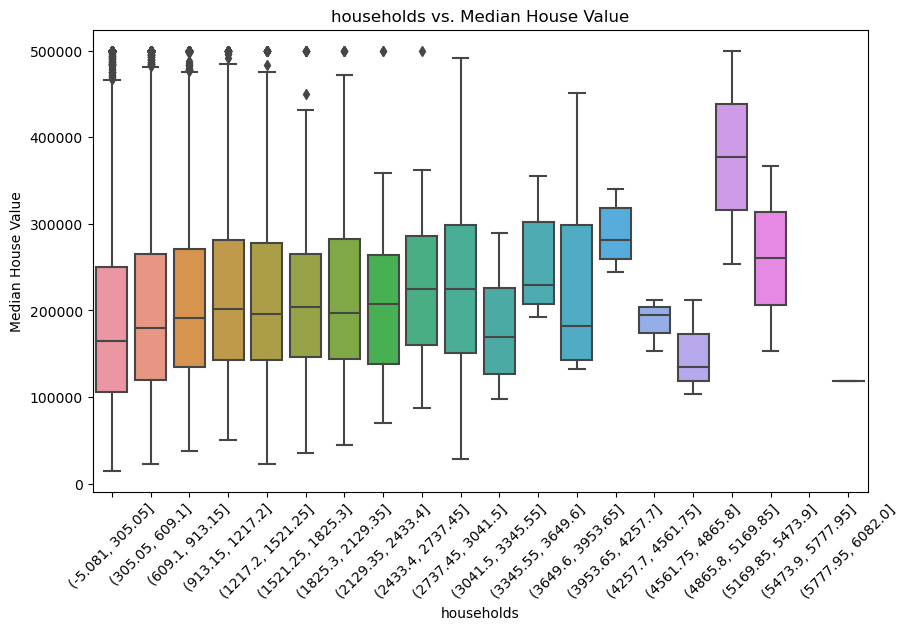

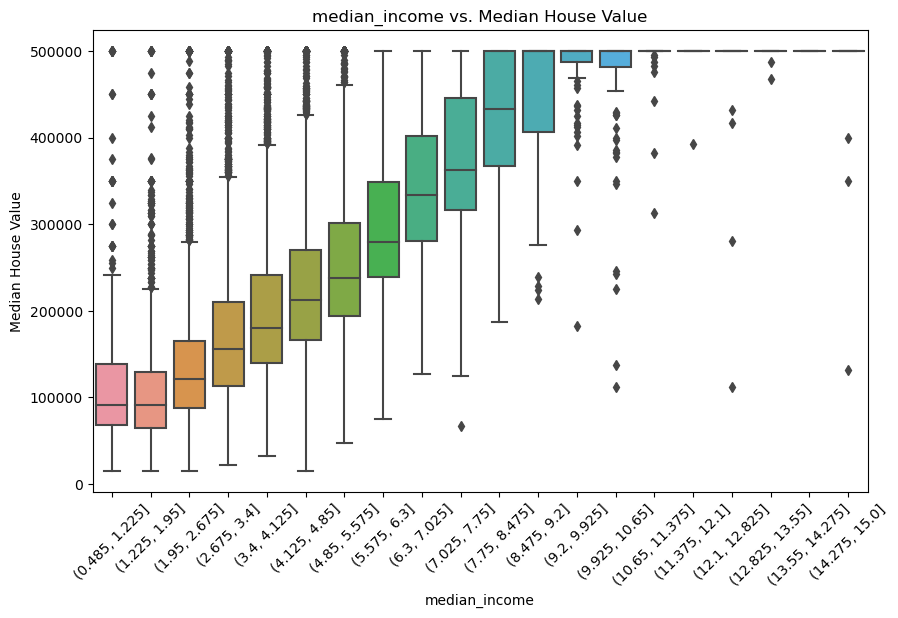

In [4]:
#Boxplot was used since there are lots of points and binning them gives a coherent graph of the dataset we have, while showing
#outliers and Q1, medians, and Q3's of our dataset.

for feature in features:
    binned_feature = pd.cut(housing_df[feature], bins=20)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=binned_feature, y=housing_df['median_house_value'])
    plt.title(f'{feature} vs. Median House Value')
    plt.xlabel(f'{feature}')
    plt.ylabel('Median House Value')
    plt.xticks(rotation=45) 
    plt.show()

For most of the features, we either cant see a direct relationship or a weak one between the feature and the median house value, However, for median_income we can see kind of a linear relationship, which is expected since have more income probably means living in better neighborhoods thus more expensive houses.



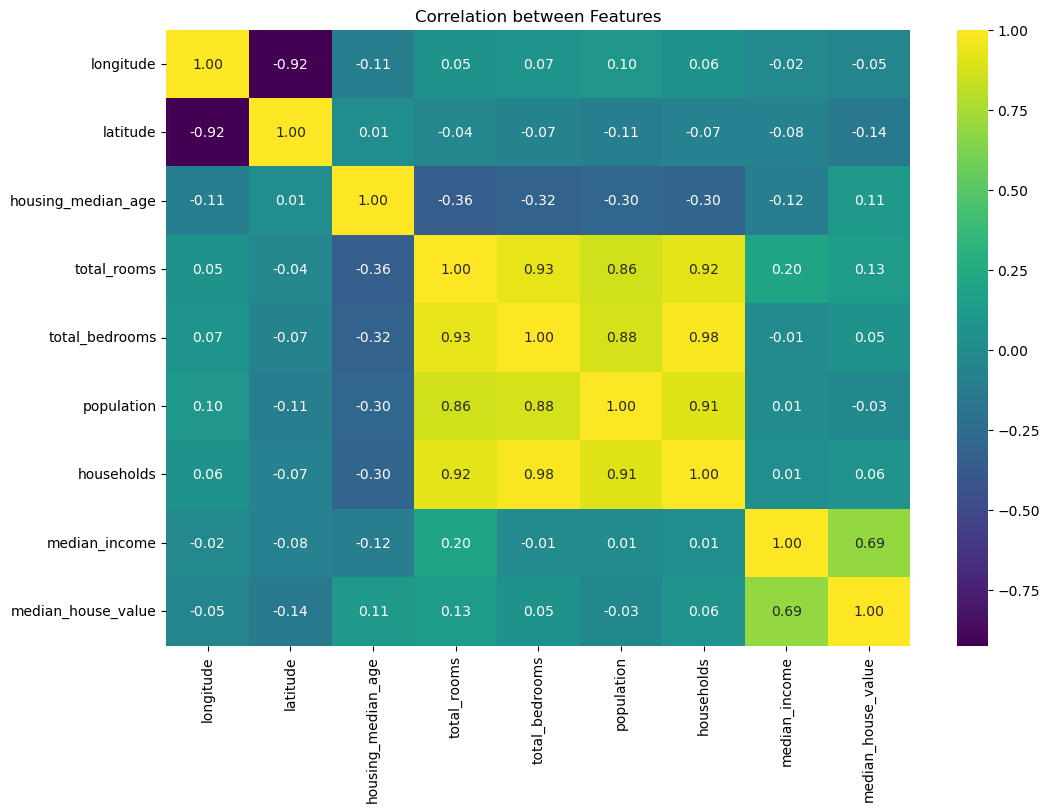

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(housing_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation between Features')
plt.show()

Alongside showing that our target value is mostly affected by median income, we can see how other features correlate to each other as well, for example we see total rooms, households, populations and total_bedrooms related to each other strongly, which is to be expected since more population means more households, and the former means more rooms and bedrooms. And other than a weak relation between median age and some features everything else isn't direclty related to neither our target feature nor other features.

## 1.2. Outlier Detection (15 Pts)
* Choose an outlier detection method and apply it to the data.
* Explain your method and why you choose it.

I chose the IQR method which is done by first calculating the Interquartile Range (75th quartile - 25th quartile) then adding 1.5 times this IQR to our Q3 to make up our rightside inner fence, and substract 1.5 times our IQR from Q1 to get our leftside inner fence. After that we detect anything that lies outside these fence values to be an outlier. 

I used the IQR method since it is less effected by extremes than other methods and while simple to calculate, has effective results.

In [6]:
#Showing outliers in our dataset, this is the way we are going to get outliers for the next part.

for feature in housing_df.columns:
    if housing_df[feature].dtype != 'object':
        Q1 = housing_df[feature].quantile(0.25)
        Q3 = housing_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (housing_df[feature] < (Q1 - 1.5 * IQR)) | (housing_df[feature] > (Q3 + 1.5 * IQR))
        outliers = housing_df[outlier_mask]
        print(f'Outliers in {feature}:\n', outliers , "\n\n")

Outliers in longitude:
 Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity]
Index: [] 


Outliers in latitude:
 Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity]
Index: [] 


Outliers in housing_median_age:
 Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity]
Index: [] 


Outliers in total_rooms:
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1        -122.22     37.86                21.0       7099.0          1106.0   
101      -122.25     37.81                28.0       5806.0          1603.0   
104      -122.26     37.81                34.0       5871.0          1914.0   
185      -122.23     37

## 1.3. Outlier Handling (15 Pts)
Try the following methods to handle outliers, creating checkpoints for each. Additionally, visualize the final data distribution after each method to identify any significant changes
1. Keep the dataset as is - take the original checkpoint for baseline comparison.
2. Outlier removal
3. Mean Imputation (Use Mode imputation for categorical variables)
4. Median Imputation (Use Mode imputation for categorical variables)

In [7]:
#Function to visulize our data

def visualize_data_distribution(df, title):
    features = df.select_dtypes(include=['float64', 'int64']).columns
    for feature in features:
        if(feature == "median_house_value"):
            continue
        plt.figure(figsize=(10, 4))
        sns.histplot(df[feature], kde=True)
        plt.title(f'{title}: Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.show()
        

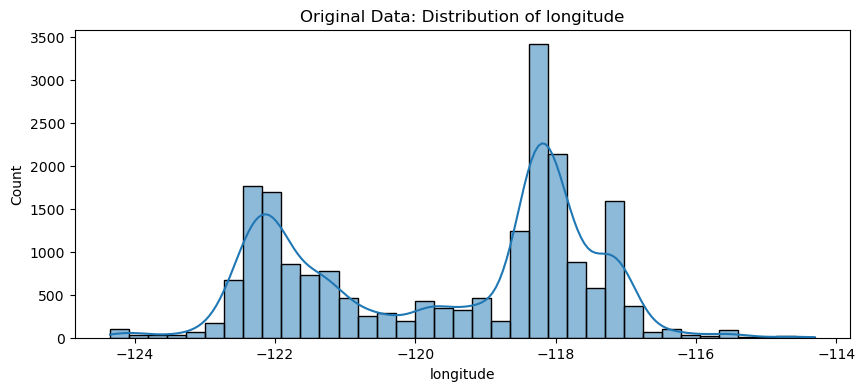

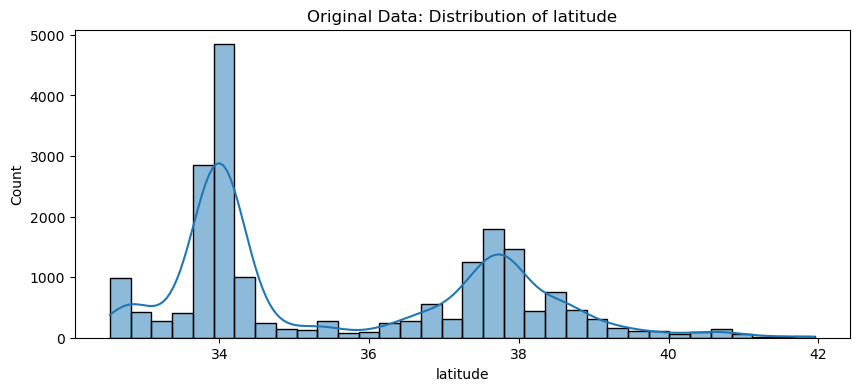

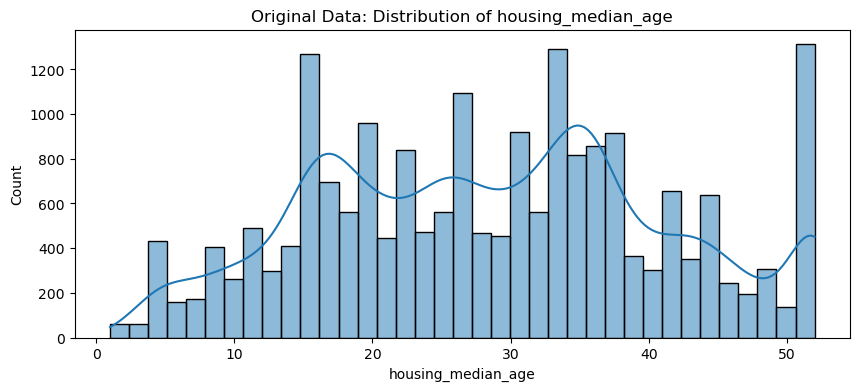

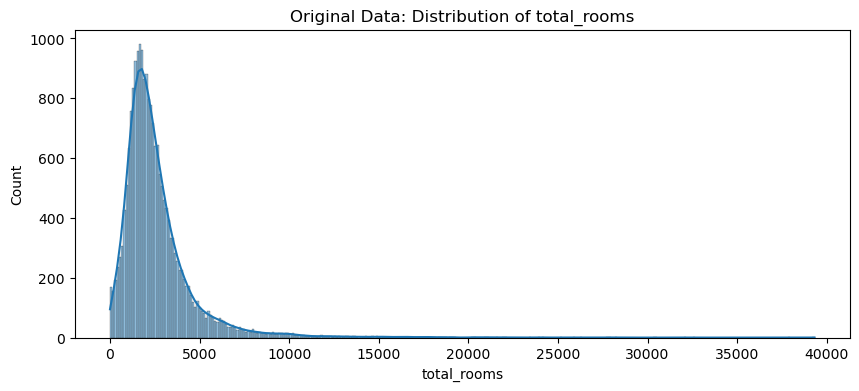

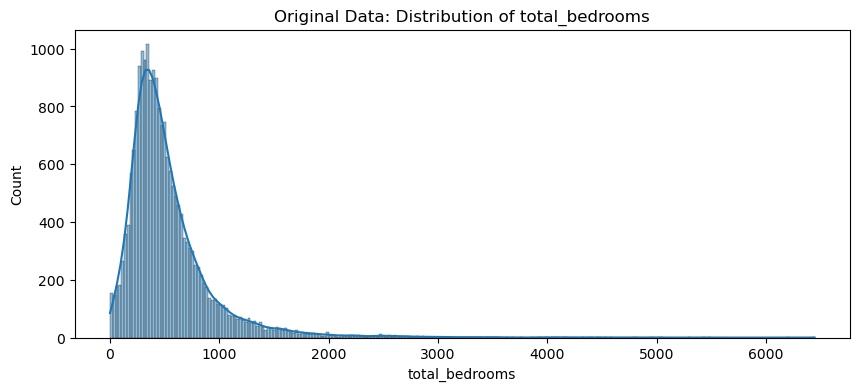

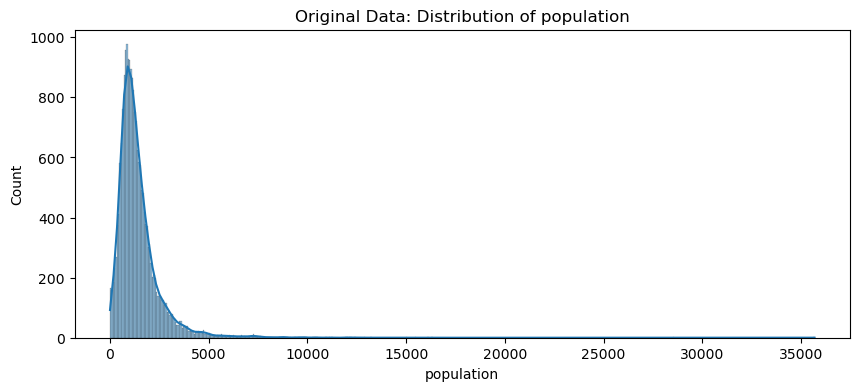

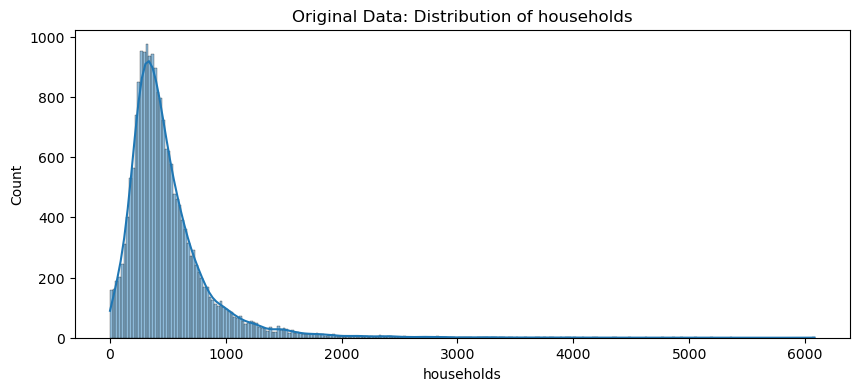

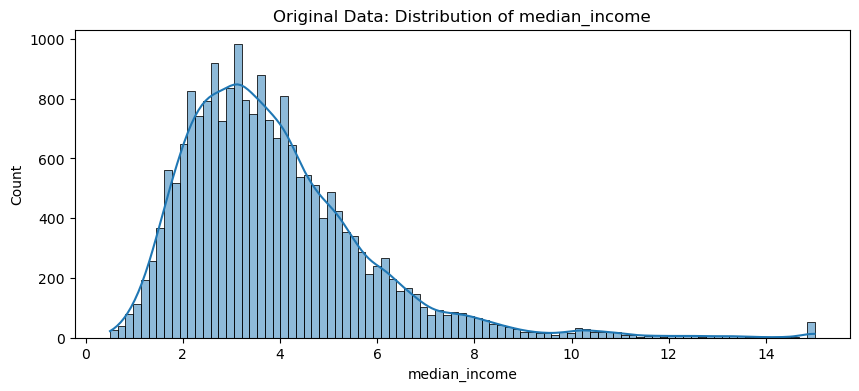

In [8]:
df_original = housing_df.copy()
visualize_data_distribution(df_original, "Original Data")

Original data, nothing changed.

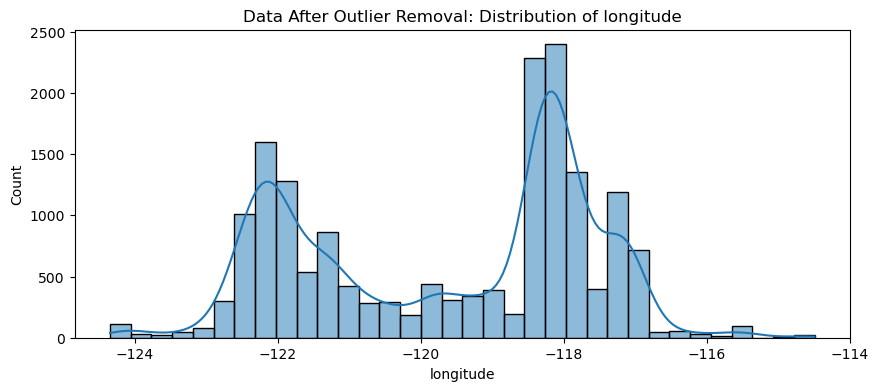

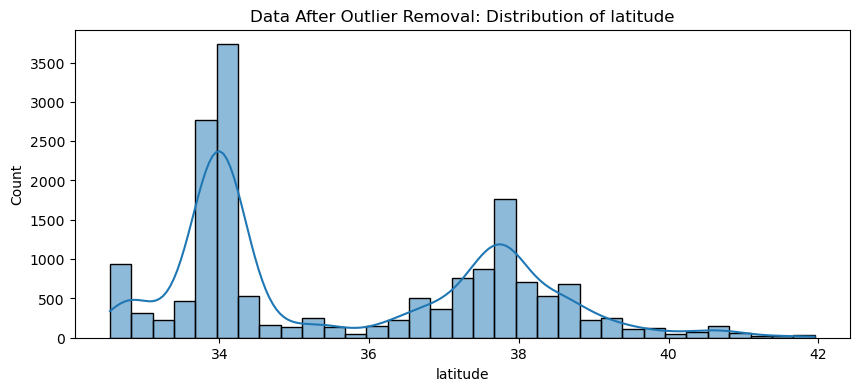

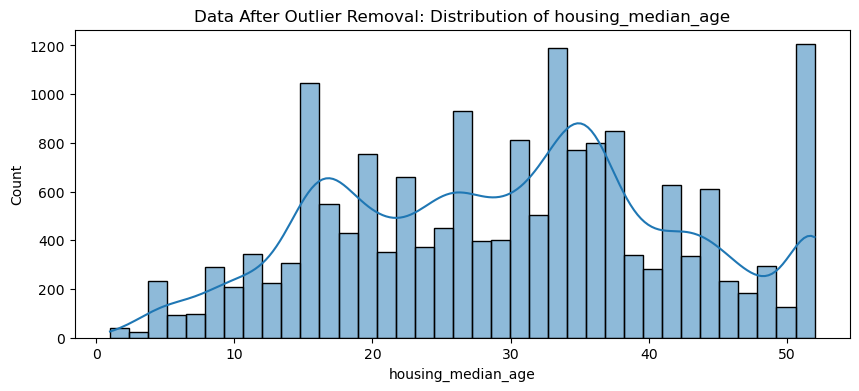

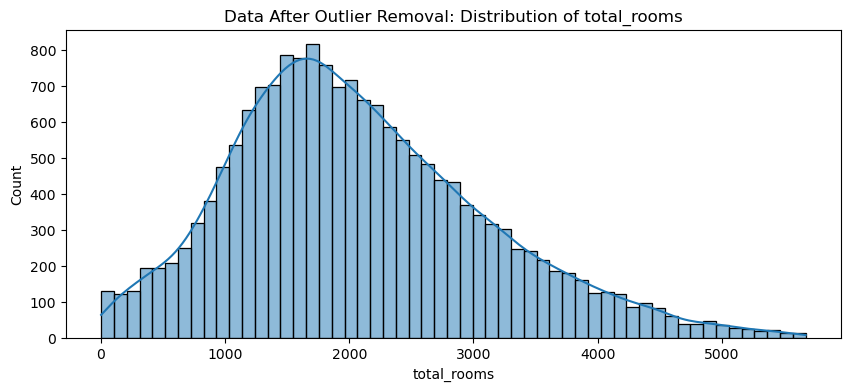

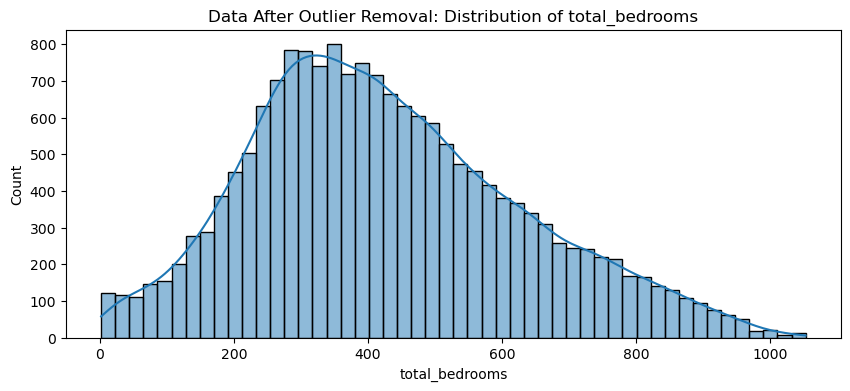

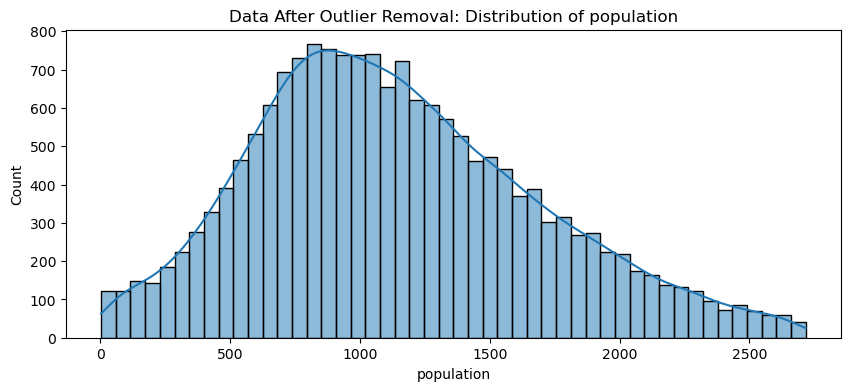

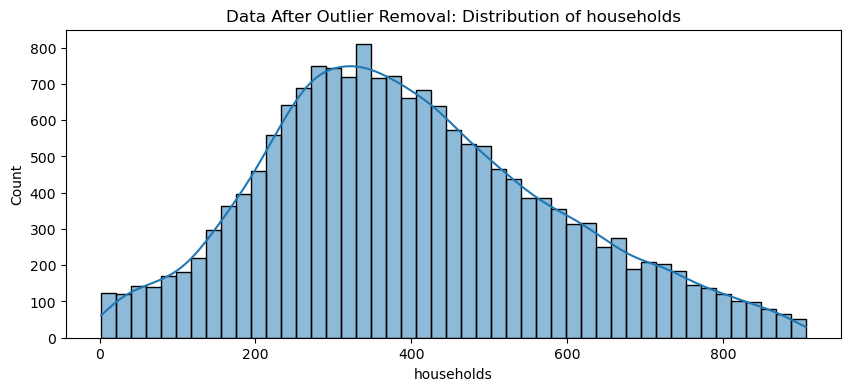

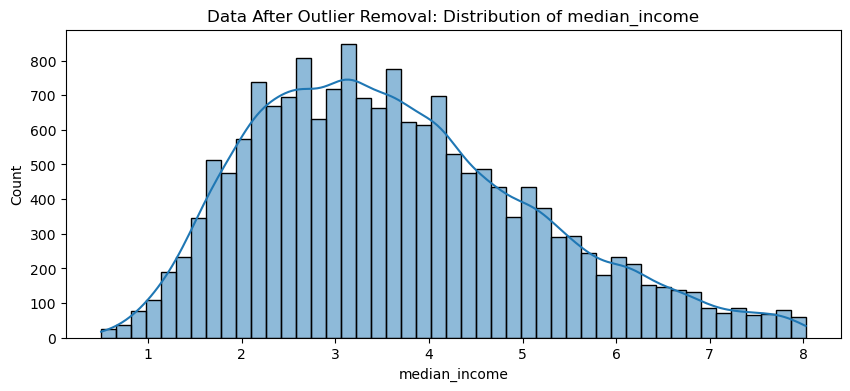

In [9]:
df_no_outliers = housing_df.copy()
target_feature = 'median_house_value'

#Takes only parts that are in the inner fences for each feature, thus removing outliers
for feature in df_no_outliers.columns:
    if feature != target_feature and df_no_outliers[feature].dtype != 'object':
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_no_outliers[feature] >= (Q1 - 1.5 * IQR)) & (df_no_outliers[feature] <= (Q3 + 1.5 * IQR))
        df_no_outliers = df_no_outliers.loc[outlier_mask]

visualize_data_distribution(df_no_outliers, "Data After Outlier Removal")


We can see outliers removed in our dataset

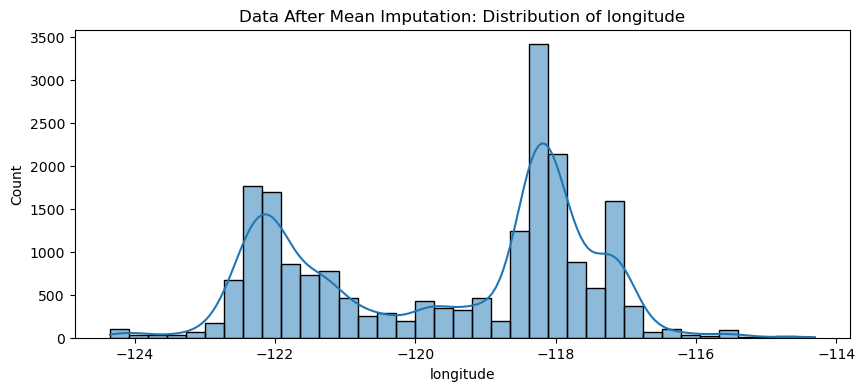

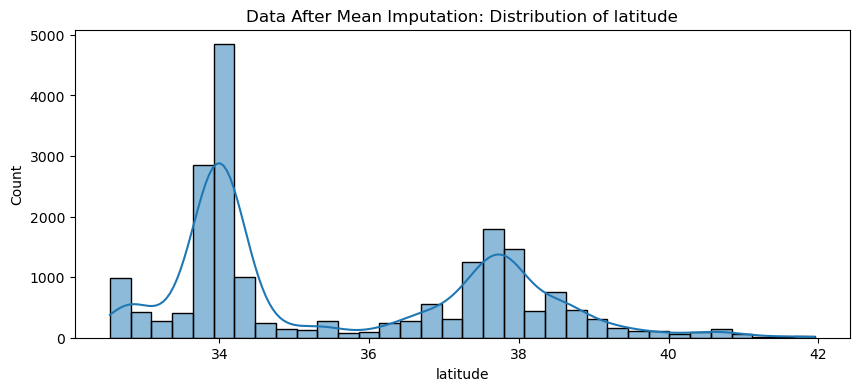

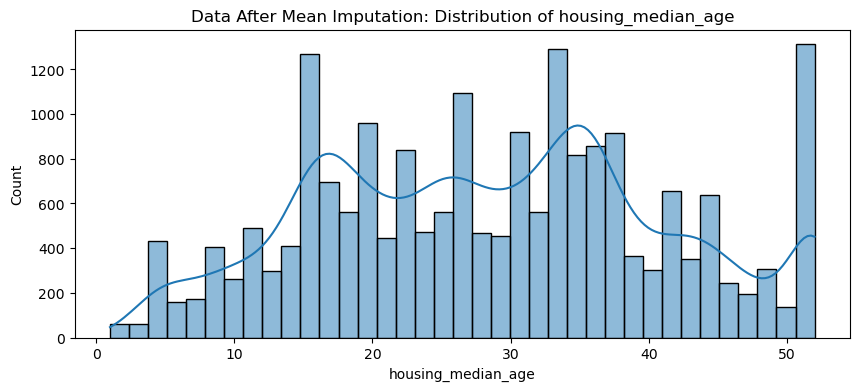

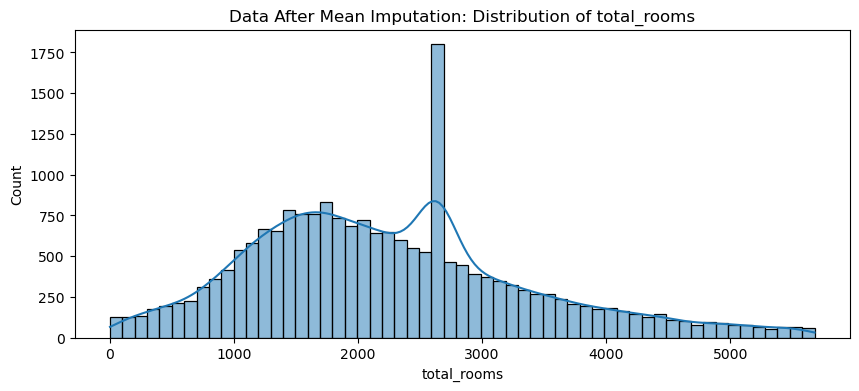

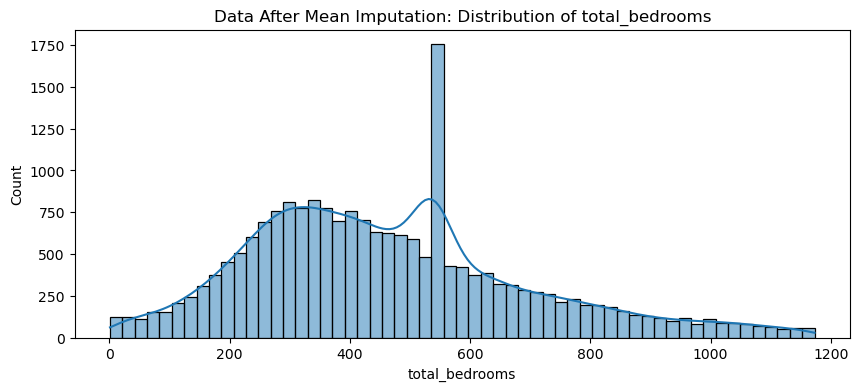

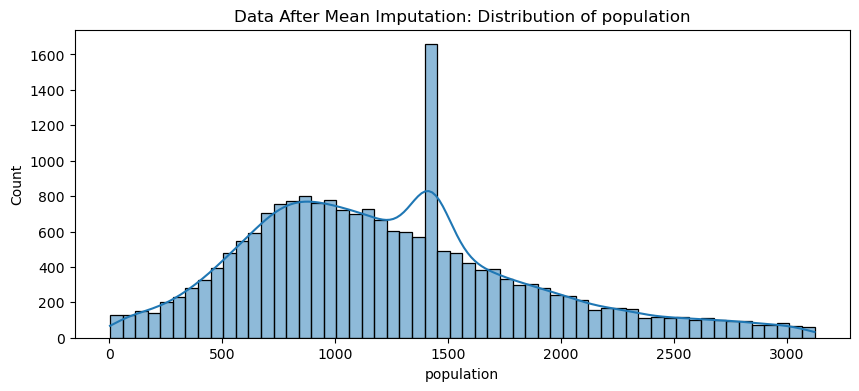

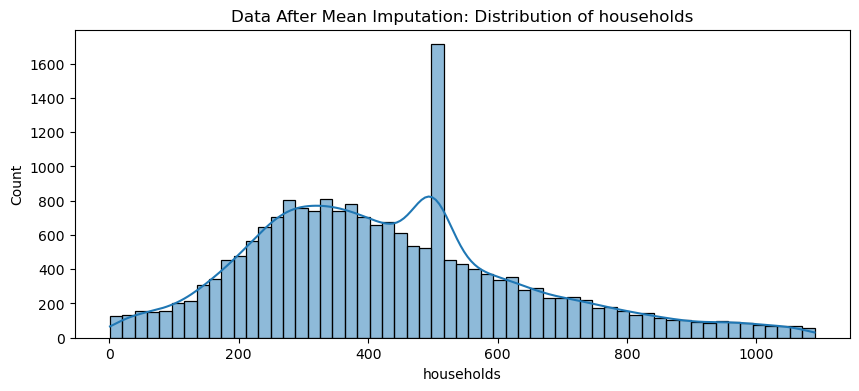

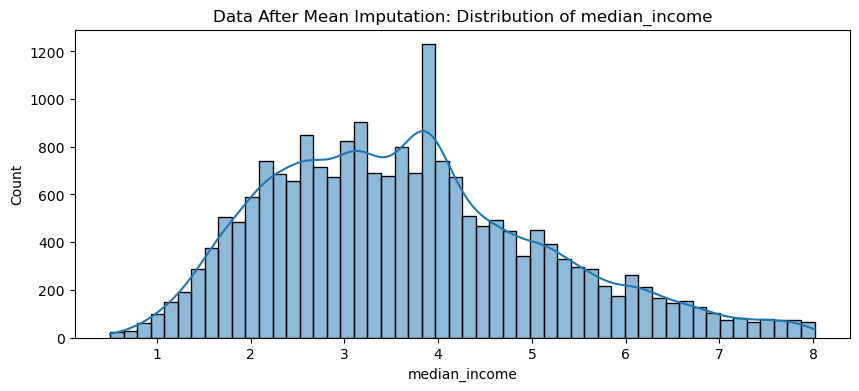

In [10]:
df_mean_imputation = housing_df.copy()

#Chnages outliers' values to mean of the feature.
for feature in df_mean_imputation.columns:
    if feature != target_feature and df_mean_imputation[feature].dtype != 'object':
        mean_value = df_mean_imputation[feature].mean()
        Q1 = df_mean_imputation[feature].quantile(0.25)
        Q3 = df_mean_imputation[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_mean_imputation[feature] < (Q1 - 1.5 * IQR)) | (df_mean_imputation[feature] > (Q3 + 1.5 * IQR))
        df_mean_imputation.loc[outlier_mask, feature] = mean_value

visualize_data_distribution(df_mean_imputation, "Data After Mean Imputation")

Since we have alot of outliers spread out in our distribution, there happens to be a large spike in most features which might give inaccurate results later.

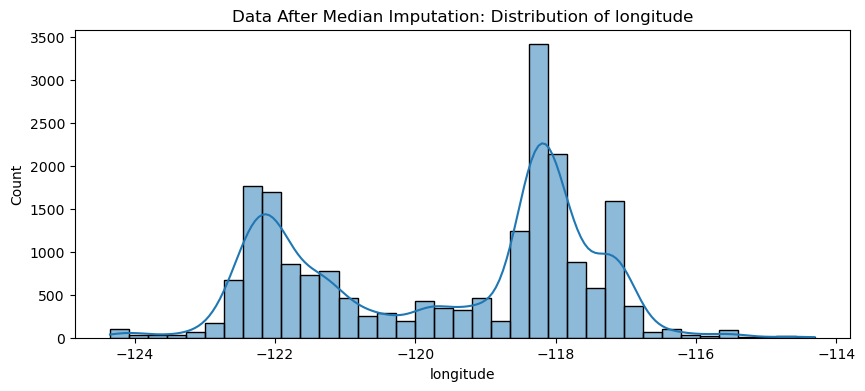

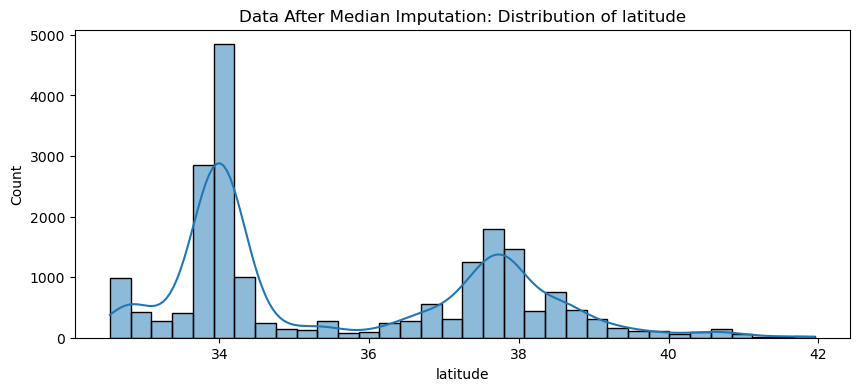

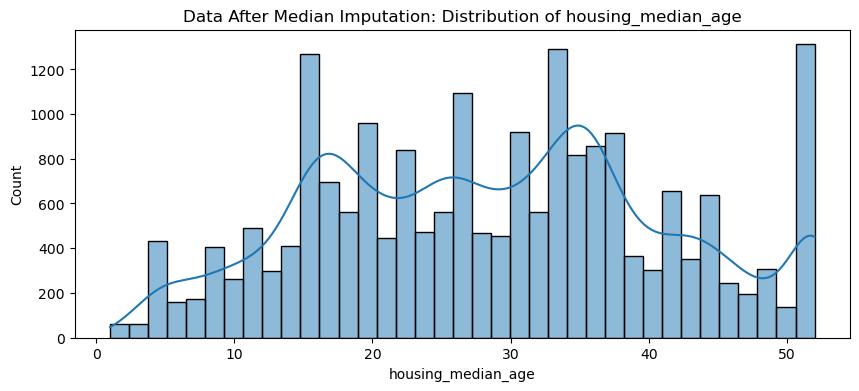

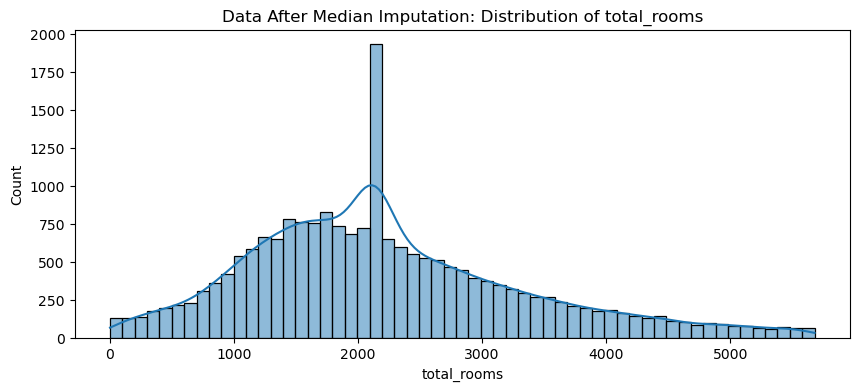

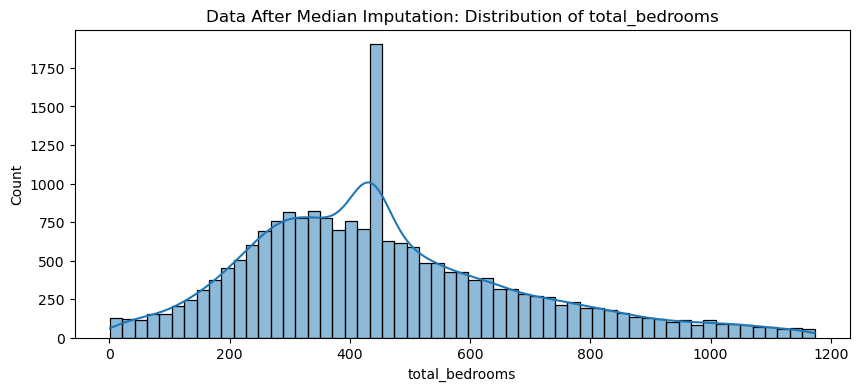

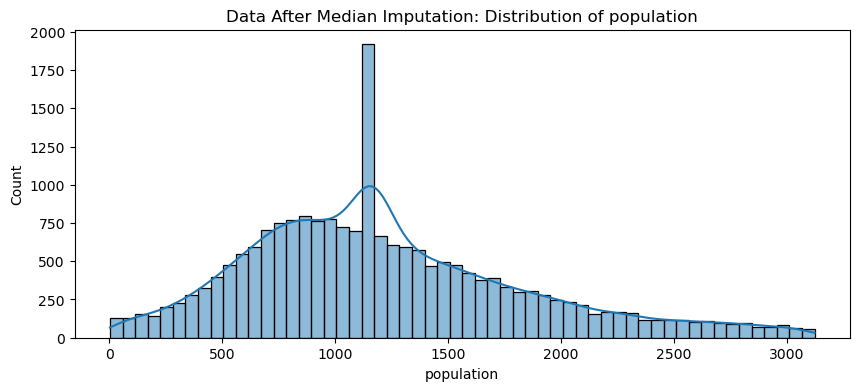

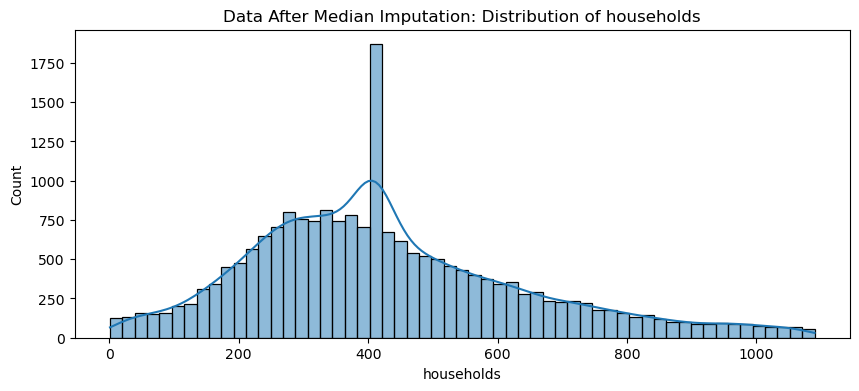

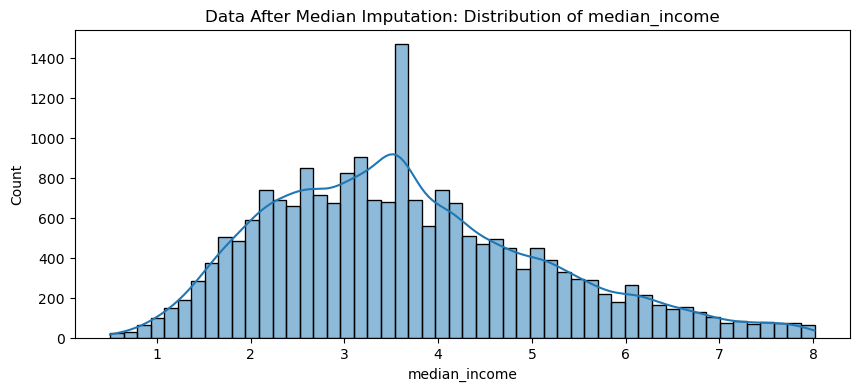

In [11]:
df_median_imputation = housing_df.copy()

#Changes outliers' values to set's median
for feature in df_median_imputation.columns:
    if feature != target_feature and df_median_imputation[feature].dtype != 'object':
        median_value = df_median_imputation[feature].median()
        Q1 = df_median_imputation[feature].quantile(0.25)
        Q3 = df_median_imputation[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_median_imputation[feature] < (Q1 - 1.5 * IQR)) | (df_median_imputation[feature] > (Q3 + 1.5 * IQR))
        df_median_imputation.loc[outlier_mask, feature] = median_value

visualize_data_distribution(df_median_imputation, "Data After Median Imputation")

We can see a similar problem here.

## 1.4. Encode the Ordinal Features with Ordinal Encoding (2 Pts)

In [12]:
#defined as a function to be used in later parts
#We can see from our dataset that our only ordinal feature is "ocean_proximity"

def ordinalEncoder(df):
    order = ['NEAR BAY', 'NEAR OCEAN', '<1H OCEAN', 'INLAND', 'ISLAND']

    encoder = OrdinalEncoder(categories=[order])
    df['ocean_proximity'] = encoder.fit_transform(df[['ocean_proximity']])

ordinalEncoder(housing_df)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0


## 1.5. Manually shuffle the dataset and split it into training (70%) and testing (30%) sets. Write your own code for shuffling and splitting, avoiding the use of pre-defined functions like train_test_split." (8 Pts)

You  cannot use scikit-learn's shuffle.

In [13]:
#This is also defined as a function to be used later. a seed is used to make reuslts reproducable.

def setSplitter(df, trainSize):
    shuffled_df = df.sample(frac=1, random_state=40).reset_index(drop=True)
    
    split_index = int(0.7 * len(shuffled_df))
    
    train_set = shuffled_df.iloc[:split_index]
    test_set = shuffled_df.iloc[split_index:]
    
    return train_set, test_set

# 2. REGRESSION (50 Pts)
* Target value: median_house_value
* Predictors: The rest

## 2.1. kNN Regression (20 Pts)
* For each version of the dataset (original, outlier-removed, mean-imputed, median-imputed), execute the following steps:"
    * Split the data into train and test sets
    * Create an instance of kNN with a number of neighbors between 1-30, then fit kNN regression model to train data. Predict the test set and calculate the MSE value for each k. Plot the MSE vs k curve to decide on the optimal k. Additionally, report the R-squared value for the optimal k.
* Compare the MSE values for each dataset and comment on the results. Which dataset gives the best result? Why do you think that is?

You can use scikit-learn's KNeighborsRegressor.

In [14]:
#Encodes the oridnal feature "ocean_proximity" for the dataframes we are going to use

ordinalEncoder(df_original)
ordinalEncoder(df_no_outliers)
ordinalEncoder(df_mean_imputation)
ordinalEncoder(df_median_imputation)

In [15]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score



def apply_knn_regression(df):
    
    trainSet, testSet = setSplitter(df, 0.7)
    
    featureTrain = trainSet.drop('median_house_value', axis=1)
    targetTrain = trainSet['median_house_value']
    
    featureTest = testSet.drop('median_house_value', axis=1)
    targetTest = testSet['median_house_value']

    mse_values = []
    k_values = range(1, 31)

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)

        knn.fit(featureTrain, targetTrain)

        y_pred = knn.predict(featureTest)
        mse = mean_squared_error(targetTest, y_pred)
        mse_values.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mse_values, marker='o')
    plt.title('MSE vs. k for kNN Regression')
    plt.xlabel('Number of Neighbors: k')
    plt.ylabel('Mean Squared Error')
    plt.show()

    optimal_k = k_values[mse_values.index(min(mse_values))]

    knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)
    knn_optimal.fit(featureTrain, targetTrain)
    y_pred_optimal = knn_optimal.predict(featureTest)
    r_squared = r2_score(targetTest, y_pred_optimal)

    return min(mse_values), r_squared, optimal_k

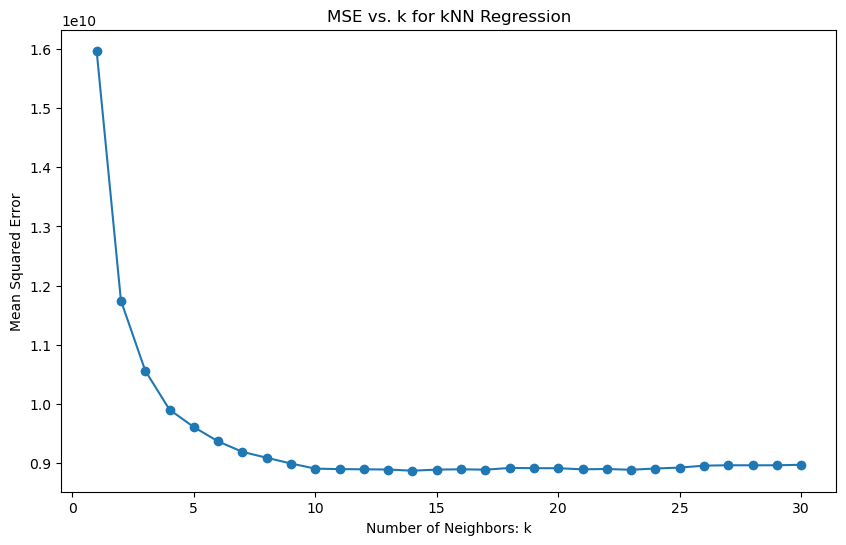

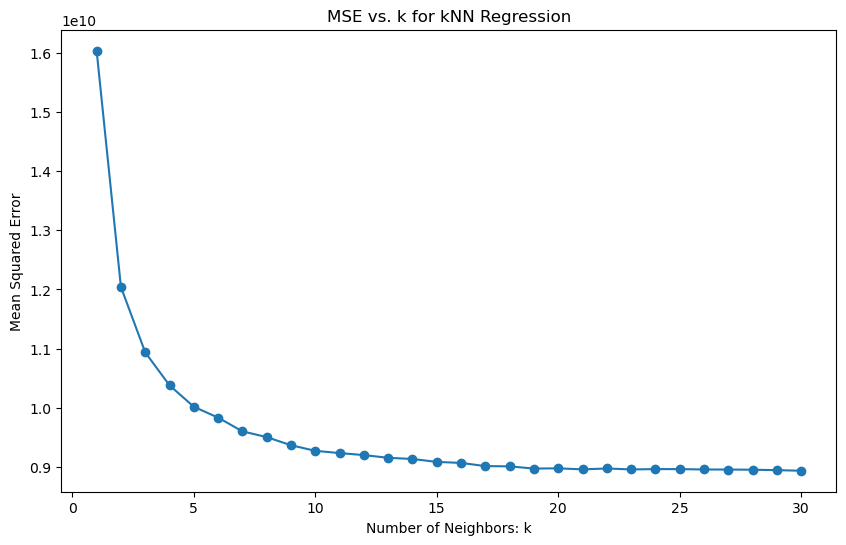

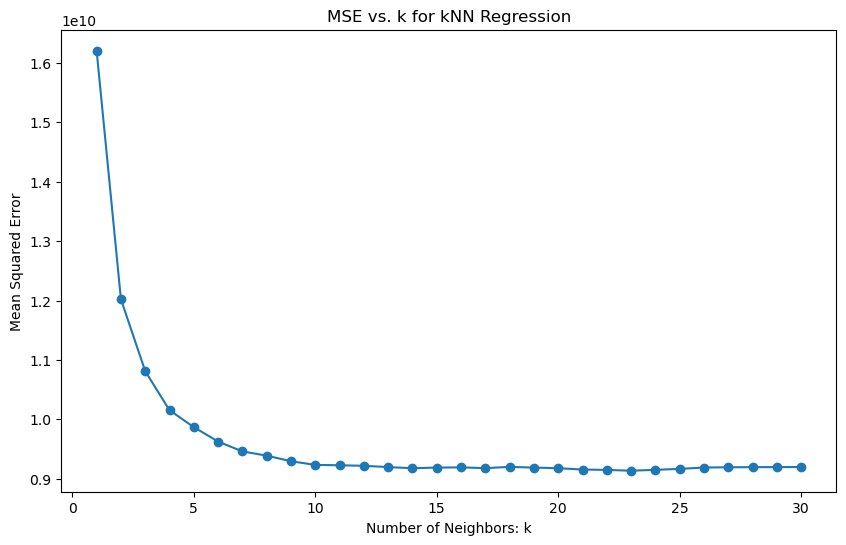

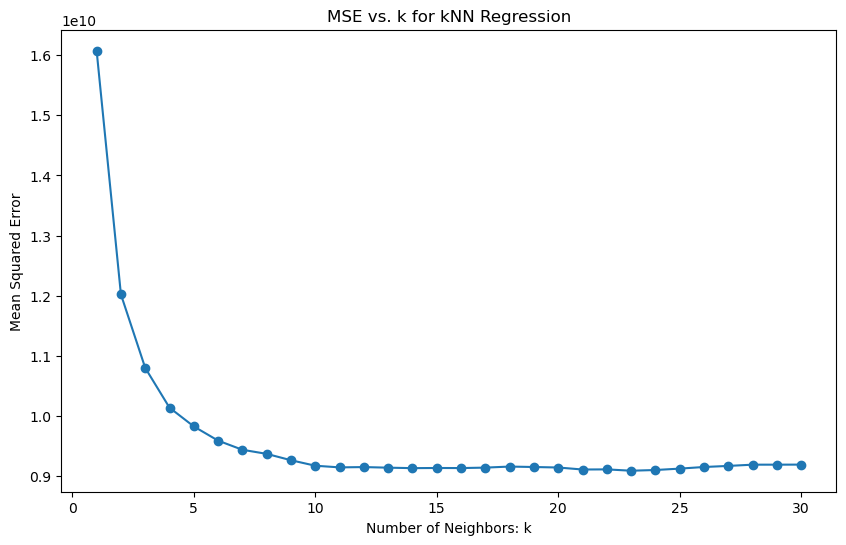

Original Dataset: MSE = 8866091136.950819, R-squared = 0.3338013213092895, Optimal k = 14
No Outliers Dataset: MSE = 8932809779.152914, R-squared = 0.2172710440216301, Optimal k = 30
Mean Imputation Dataset: MSE = 9133961461.658863, R-squared = 0.31367352726516884, Optimal k = 23
Median Imputation Dataset: MSE = 9088818509.63813, R-squared = 0.31706557168743643, Optimal k = 23


In [16]:
mse_original, r2_original, k_original = apply_knn_regression(df_original)
mse_no_outliers, r2_no_outliers, k_no_outliers = apply_knn_regression(df_no_outliers)
mse_mean_imputation, r2_mean_imputation, k_mean_imputation = apply_knn_regression(df_mean_imputation)
mse_median_imputation, r2_median_imputation, k_median_imputation = apply_knn_regression(df_median_imputation)

print(f"Original Dataset: MSE = {mse_original}, R-squared = {r2_original}, Optimal k = {k_original}")
print(f"No Outliers Dataset: MSE = {mse_no_outliers}, R-squared = {r2_no_outliers}, Optimal k = {k_no_outliers}")
print(f"Mean Imputation Dataset: MSE = {mse_mean_imputation}, R-squared = {r2_mean_imputation}, Optimal k = {k_mean_imputation}")
print(f"Median Imputation Dataset: MSE = {mse_median_imputation}, R-squared = {r2_median_imputation}, Optimal k = {k_median_imputation}")


Here we can see that the original dataset scored the best with k = 14, its MSE value is the lowest and and R-squared value is the highest. We can see mean and median imputation coming next and the dataset with no outliers being the worst by a big difference, this could be because of the limitation applied to it with it capping at k = 30. Original dataset might be the best because both median and mean imputations gave some unrealistic results with really high count values, while there are lots of high outliers, while the no outliers dataset completely removed them.

## 2.2. Linear Regression (20 Pts)
* For each version of the dataset (original, outlier removal, mean imputation, median imputation), do the following:
    * Split the data into train and test sets
    * Fit a linear regression model to train data. Predict the test set and calculate the MSE value.

In [17]:
from sklearn.linear_model import LinearRegression

def linear_regression_analysis(df):
    train_set, test_set = setSplitter(df, 0.7)
    
    featureTrain = train_set.drop('median_house_value', axis=1)
    targetTrain = train_set['median_house_value']
    
    featureTest = test_set.drop('median_house_value', axis=1)
    targetTest = test_set['median_house_value']
    
    model = LinearRegression()
    model.fit(featureTrain, targetTrain)
    
    y_pred = model.predict(featureTest)
    
    mse = mean_squared_error(targetTest, y_pred)
    return mse


In [18]:
mse_original = linear_regression_analysis(df_original)
mse_no_outliers = linear_regression_analysis(df_no_outliers)
mse_mean_imputation = linear_regression_analysis(df_mean_imputation)
mse_median_imputation = linear_regression_analysis(df_median_imputation)

print(f"Original Dataset MSE: {mse_original}")
print(f"No Outliers Dataset MSE: {mse_no_outliers}")
print(f"Mean Imputation Dataset MSE: {mse_mean_imputation}")
print(f"Median Imputation Dataset MSE: {mse_median_imputation}")

Original Dataset MSE: 4685942955.942905
No Outliers Dataset MSE: 4532721478.606831
Mean Imputation Dataset MSE: 6725114257.427887
Median Imputation Dataset MSE: 6998745525.817817


So for linear regression the no outliers dataset is the best with the lowest MSE, with a small difference between it and the original dataset. Coming after them mean imputation and median imputation with highest MSE.

## 2.3. Compare the Regression Methods (10 Pts)

Compare and contrast the performance of kNN and Linear Regression models across the different dataset versions (those attained in 1.3.). Discuss the strengths and limitations of each model based on your results

\< Linear regression appeared to be better for all dataset variations than KNN for k in range 1 - 30 since it had lower MSE values (ranging from 30% - 50% less), which makes it a better model for this dataset. This might be because KNN is more sensitive to noise in data, which we saw in our distributions and heatmaps, where there are no direct relationships between features and target feature other than median income. However, linear regression is more robust to noisy data and is better at showing a linear relationship, which is the case for median income - median house value. Linear regression also is better when number of features is higher which might also be a factor for it performing better in our case where there are 8 features   \>

# PLAGIARISM POLICY

In the interest of maintaining a fair and honest academic environment, this course strictly adheres to a zero-tolerance policy regarding plagiarism. 
Accordingly, all assignments must reflect individual effort and understanding. While abstract discussions with peers about concepts are encouraged, sharing or copying specific solutions, code, or pseudocode is not permitted and will be treated as plagiarism. This policy includes work sourced from the internet, publications, and AI tools like ChatGPT and GitHub Copilot. **MAKE USE OF THEM RESPONSIBLY**. That is, you can utilize them to enhance understanding and support your original work, **not to replace it**. Submitting work that is not entirely your own creation will be regarded as a violation of academic integrity. It is vital to use all resources, including AI, in a manner that supports your educational development without compromising the principles of academic honesty. 

If in doubt, do not hesitate to seek guidance from the course staff - we are here to help, with an aim to foster a learning environment based on trust, respect, and responsibility.

# REFERENCES
[1] Nugent, C. (n.d.). California Housing Prices [Data set]. Kaggle. Retrieved from https://www.kaggle.com/datasets/camnugent/california-housing-prices